INSTALLATIONS & IMPORTS

In [ ]:
!pip install qiskit==2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 15.6 MB/s eta 0:00:00


In [ ]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 54.9 MB/s eta 0:00:00


In [ ]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=775864ae5cd62bd972d9b07f460644f1d9557cf518f3ac16443ecc0629b1a45b
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Estimator
from qiskit.circuit import Parameter
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize
from math import pi

DATASET PREPARATION

In [ ]:
X, y = make_moons(n_samples=200, noise=0.15, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ENCODER

In [ ]:
def encoder_circuit(x):
    #Feature map encoding input x into rotations and entanglement.
    qc = QuantumCircuit(2)
    qc.ry(x[0], 0)
    qc.ry(x[1], 1)
    qc.cx(0, 1)
    qc.rz(x[0]*x[1], 1)
    qc.cx(0, 1)
    return qc

In [ ]:
print("=== Encoder Circuit Uφ(x) Example ===")
print(encoder_circuit([0.3, 0.5]).draw(output='text'))

=== Encoder Circuit Uφ(x) Example ===
     ┌─────────┐                      
q_0: ┤ Ry(0.3) ├──■────────────────■──
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐
q_1: ┤ Ry(0.5) ├┤ X ├┤ Rz(0.15) ├┤ X ├
     └─────────┘└───┘└──────────┘└───┘


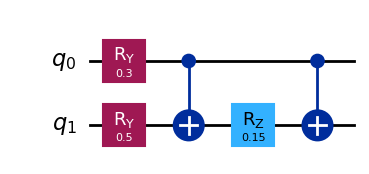

In [ ]:
encoder_circuit([0.3, 0.5]).draw('mpl')

VARIATIONAL CIRCUIT

In [ ]:
θ = [Parameter(f"θ{i}") for i in range(4)]

def variational_circuit():
    qc = QuantumCircuit(2)
    qc.ry(θ[0], 0)
    qc.ry(θ[1], 1)
    qc.cx(0, 1)
    qc.ry(θ[2], 0)
    qc.ry(θ[3], 1)
    qc.cx(0, 1)
    return qc

In [ ]:
var_circ = variational_circuit()

def full_circuit(x):
    qc = QuantumCircuit(2)
    qc.compose(encoder_circuit(x), inplace=True)
    qc.compose(var_circ, inplace=True)
    return qc

In [ ]:
print("\n=== Variational Circuit Uθ ===")
print(var_circ.draw(output='text'))


=== Variational Circuit Uθ ===
     ┌────────┐     ┌────────┐     
q_0: ┤ Ry(θ0) ├──■──┤ Ry(θ2) ├──■──
     ├────────┤┌─┴─┐├────────┤┌─┴─┐
q_1: ┤ Ry(θ1) ├┤ X ├┤ Ry(θ3) ├┤ X ├
     └────────┘└───┘└────────┘└───┘


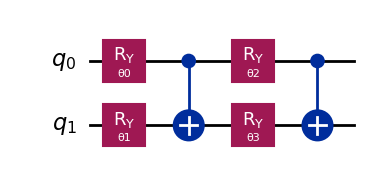

In [ ]:
import pylatexenc
var_circ.draw('mpl')

In [ ]:
example_qc = full_circuit(X_train[0])
example_qc = example_qc.assign_parameters({θ[i]: opt_params[i] for i in range(4)})

#text diagram (works everywhere)
print(example_qc.draw(output='text'))

     ┌─────────────┐                         ┌────────────┐     ┌────────────┐»
q_0: ┤ Ry(-1.3039) ├──■───────────────────■──┤ Ry(5.8254) ├──■──┤ Ry(3.3344) ├»
     └┬────────────┤┌─┴─┐┌─────────────┐┌─┴─┐├────────────┤┌─┴─┐├────────────┤»
q_1: ─┤ Ry(1.0141) ├┤ X ├┤ Rz(-1.3223) ├┤ X ├┤ Ry(1.7011) ├┤ X ├┤ Ry(3.1216) ├»
      └────────────┘└───┘└─────────────┘└───┘└────────────┘└───┘└────────────┘»
«          
«q_0: ──■──
«     ┌─┴─┐
«q_1: ┤ X ├
«     └───┘


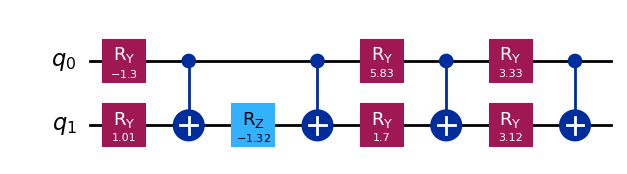

In [ ]:
example_qc.draw('mpl')

CIRCUIT LEARNING

In [ ]:
from qiskit.quantum_info import SparsePauliOp
estimator = Estimator()        # Qiskit ≥ 2.0
observable = SparsePauliOp.from_list([("ZI", 1.0)])   # Z on q0, I on q1

def predict_prob(x, params):
    """Return probability p(y=1|x) using Estimator primitive"""
    qc = full_circuit(x)
    # evaluate expectation value <Z⊗I>
    result = estimator.run(
        circuits=[qc],
        observables=[observable],
        parameter_values=[list(params)]
    ).result()
    exp_val = result.values[0]
    return (exp_val + 1) / 2.0  # map [-1,1] → [0,1]

In [ ]:
def loss_fn(params, X, y):
    probs = np.array([predict_prob(x, params) for x in X])
    probs = np.clip(probs, 1e-9, 1 - 1e-9)
    return -np.mean(y * np.log(probs) + (1 - y) * np.log(1 - probs))

OPTIMISATION

In [ ]:
from scipy.optimize import minimize
init_params = np.random.uniform(0, 2 * np.pi, 4)
res = minimize(
    loss_fn, init_params, args=(X_train, y_train),
    method="COBYLA", options={"maxiter": 60, "disp": True}
)
opt_params = res.x

Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 51   Least value of F = 0.43994931007134674
The corresponding X is:
[5.82544124 1.70105047 3.33438909 3.12163456]



RESULTS

In [ ]:
train_probs = np.array([predict_prob(x, opt_params) for x in X_train])
test_probs = np.array([predict_prob(x, opt_params) for x in X_test])
train_preds = (train_probs > 0.5).astype(int)
test_preds = (test_probs > 0.5).astype(int)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print("\n=== Final Results ===")
print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test  Accuracy: {test_acc:.3f}")
print(f"Optimal Parameters: {opt_params}\n")


=== Final Results ===
Train Accuracy: 0.787
Test  Accuracy: 0.740
Optimal Parameters: [5.82544124 1.70105047 3.33438909 3.12163456]



PREDICTION

In [ ]:
print("\n=== PQC Predictions on Test Samples ===")
for i in range(5):  # show first 5 test points
    x = X_test[i]
    true_label = y_test[i]
    prob = predict_prob(x, opt_params)
    pred_label = int(prob > 0.5)
    print(f"Sample {i+1}: x={np.round(x,2)} → p(y=1|x)={prob:.3f} → predicted={pred_label}, actual={true_label}")


=== PQC Predictions on Test Samples ===
Sample 1: x=[ 0.01 -1.18] → p(y=1|x)=0.933 → predicted=1, actual=1
Sample 2: x=[2.06 0.46] → p(y=1|x)=0.310 → predicted=0, actual=1
Sample 3: x=[ 0.4  -1.58] → p(y=1|x)=0.900 → predicted=1, actual=1
Sample 4: x=[-0.29 -0.48] → p(y=1|x)=0.669 → predicted=1, actual=1
Sample 5: x=[ 1.48 -1.55] → p(y=1|x)=0.164 → predicted=0, actual=1
